<a href="https://colab.research.google.com/github/MauroDeMoraes/LightHouseLab_Midterm/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [277]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [278]:
pip install psycopg2-binary

In [279]:
import psycopg2
con= psycopg2.connect(database='mid_term_project', user='lhl_student',password='lhl_student',\
                      host='mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com',port='5432')

## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [280]:
df_fuel_consumption = pd.read_sql_query("""SELECT * FROM fuel_comsumption;""",con)

In [281]:
df_fuel_consumption.head()

,month,airline_id,unique_carrier,carrier,carrier_name,carrier_group_new,sdomt_gallons,satl_gallons,spac_gallons,slat_gallons,sint_gallons,ts_gallons,tdomt_gallons,tint_gallons,total_gallons,sdomt_cost,satl_cost,spac_cost,slat_cost,sint_cost,ts_cost,tdomt_cost,tint_cost,total_cost,year
0,1,NaN,None,0JQ,None,1,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,5100.0,0.0,5100.0,2016
1,1,21352.0,0WQ,0WQ,Avjet Corporation,1,0.0,0.0,0.0,0.0,0.0,0.0,163052.0,47060.0,210112.0,0.0,0.0,0.0,0.0,0.0,0.0,396216.0,140239.0,536455.0,2016
2,1,21645.0,23Q,23Q,Songbird Airways Inc.,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
3,1,21652.0,27Q,27Q,"Jet Aviation Flight Services, Inc.",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
4,1,20408.0,5V,5V,Tatonduk Outfitters Limited d/b/a Everts Air A...,1,260848.0,0.0,0.0,0.0,0.0,260848.0,284362.0,0.0,284362.0,522405.0,0.0,0.0,0.0,0.0,522405.0,569497.0,0.0,569497.0,2016


In [397]:
from google.colab import files
df_fuel_consumption.to_csv('df_fuel_consumption.csv') 
files.download('df_fuel_consumption.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [282]:
df_flights = pd.read_sql_query("""SELECT * FROM flights ORDER BY RANDOM() LIMIT 60000;""",con)

In [398]:
from google.colab import files
df_flights.to_csv('df_flights.csv') 
files.download('df_flights.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [284]:
df_flights['fl_date'] = pd.to_datetime(df_flights['fl_date'])

In [285]:
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-07-29,DL,DL,DL,2607,DL,N3743H,2607,10397,ATL,"Atlanta, GA",15304,TPA,"Tampa, FL",830,828.0,-2.0,21.0,849.0,952.0,3.0,957,955.0,-2.0,0.0,None,0.0,N,87.0,87.0,63.0,1.0,406.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,2019-06-27,DL,DL,DL,881,DL,N373DX,881,10397,ATL,"Atlanta, GA",10423,AUS,"Austin, TX",1334,1337.0,3.0,12.0,1349.0,1437.0,8.0,1452,1445.0,-7.0,0.0,None,0.0,N,138.0,128.0,108.0,1.0,813.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
2,2019-01-31,HA,HA,HA,360,HA,N478HA,360,13830,OGG,"Kahului, HI",12402,ITO,"Hilo, HI",1721,1720.0,-1.0,7.0,1727.0,1751.0,6.0,1800,1757.0,-3.0,0.0,None,0.0,N,39.0,37.0,24.0,1.0,121.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
3,2019-05-14,G4,G4,G4,2953,G4,241NV,2953,11618,EWR,"Newark, NJ",15412,TYS,"Knoxville, TN",1100,1049.0,-11.0,34.0,1123.0,1256.0,7.0,1300,1303.0,3.0,0.0,None,0.0,N,120.0,134.0,93.0,1.0,631.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
4,2018-08-07,DL,DL,DL,2192,DL,N815DN,2192,15304,TPA,"Tampa, FL",11433,DTW,"Detroit, MI",623,619.0,-4.0,11.0,630.0,838.0,6.0,900,844.0,-16.0,0.0,None,0.0,N,157.0,145.0,128.0,1.0,983.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None


In [286]:
df_passengers = pd.read_sql_query("""SELECT * FROM passengers ORDER BY RANDOM() LIMIT 60000;""",con)

In [287]:
df_passengers.shape
df_passengers

,departures_scheduled,departures_performed,payload,seats,passengers,freight,mail,distance,ramp_to_ramp,air_time,unique_carrier,airline_id,unique_carrier_name,region,carrier,carrier_name,carrier_group,carrier_group_new,origin_airport_id,origin_city_market_id,origin,origin_city_name,origin_country,origin_country_name,dest_airport_id,dest_city_market_id,dest,dest_city_name,dest_country,dest_country_name,aircraft_group,aircraft_type,aircraft_config,year,month,distance_group,class,data_source
0,0.0,1.0,550.0,3.0,0.0,0.0,0.0,32.0,29.0,25.0,K2,21820,"Paklook Air, Inc d/b/a/ Airlift Alaska d/b/a/ ...",D,K2,"Paklook Air, Inc d/b/a/ Airlift Alaska d/b/a/ ...",1,5,11492,31492,EEK,"Eek, AK",US,United States,12853,32853,KWN,"Quinhagak, AK",US,United States,0,36,3,2019,3,1,F,DU
1,3.0,3.0,62920.0,228.0,160.0,0.0,0.0,245.0,228.0,153.0,OH,20397,PSA Airlines Inc.,D,OH,PSA Airlines Inc.,2,2,10990,30990,CHO,"Charlottesville, VA",US,United States,11057,31057,CLT,"Charlotte, NC",US,United States,6,638,1,2017,6,1,F,DU
2,0.0,1.0,34000.0,166.0,147.0,0.0,0.0,287.0,66.0,48.0,G4,20368,Allegiant Air,D,G4,Allegiant Air,3,3,12320,32320,ILG,"Wilmington, DE",US,United States,14574,34574,ROA,"Roanoke, VA",US,United States,6,655,1,2017,9,1,L,DU
3,0.0,1.0,6486.0,13.0,5.0,0.0,0.0,5812.0,0.0,0.0,0RQ,21309,TAG Aviation Espana S.L.,I,0RQ,TAG Aviation Espana S.L.,0,0,13156,31584,MAD,"Madrid, Spain",ES,Spain,14771,32457,SFO,"San Francisco, CA",US,United States,6,750,1,2016,12,12,L,IF
4,0.0,1.0,57000.0,0.0,0.0,0.0,0.0,128.0,48.0,36.0,GFQ,20166,Gulf And Caribbean Cargo,I,GFQ,Gulf And Caribbean Cargo,1,1,13514,33514,MTY,"Monterrey, Mexico",MX,Mexico,13061,33038,LRD,"Laredo, TX",US,United States,7,715,2,2019,1,1,P,IU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,117.0,87.0,4502620.0,15839.0,15156.0,3631.0,6630.0,1747.0,20438.0,18194.0,DL,19790,Delta Air Lines Inc.,D,DL,Delta Air Lines Inc.,3,3,12889,32211,LAS,"Las Vegas, NV",US,United States,10397,30397,ATL,"Atlanta, GA",US,United States,6,622,1,2015,6,4,F,DU
59996,65.0,65.0,2729772.0,11599.0,10216.0,2774.0,49147.0,413.0,5718.0,4293.0,UA,19977,United Air Lines Inc.,D,UA,United Air Lines Inc.,3,3,12264,30852,IAD,"Washington, DC",US,United States,10721,30721,BOS,"Boston, MA",US,United States,6,634,1,2017,4,1,F,DU
59997,10.0,9.0,159660.0,585.0,445.0,0.0,0.0,341.0,758.0,519.0,EV,20366,ExpressJet Airlines LLC,D,EV,ExpressJet Airlines Inc.,3,3,12448,32448,JAN,"Jackson/Vicksburg, MS",US,United States,10397,30397,ATL,"Atlanta, GA",US,United States,6,631,1,2017,6,1,F,DU
59998,7.0,6.0,243020.0,960.0,762.0,1848.0,10221.0,1535.0,1420.0,1255.0,DL,19790,Delta Air Lines Inc.,D,DL,Delta Air Lines Inc.,3,3,13487,31650,MSP,"Minneapolis, MN",US,United States,12892,32575,LAX,"Los Angeles, CA",US,United States,6,614,1,2015,11,4,F,DU


In [400]:
from google.colab import files
df_passengers.to_csv('df_passengers.csv') 
files.download('df_passengers.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [288]:
x =df_flights[df_flights['arr_delay']>0]

In [289]:
x = x['arr_delay']

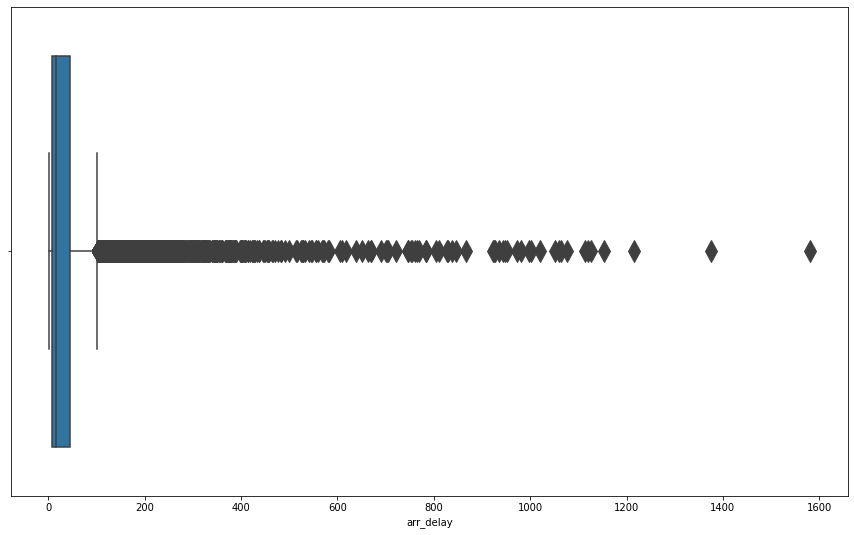

In [290]:
fig, ax = plt.subplots(figsize = (15,9))
ax = sns.boxplot(x= x ,fliersize=15, )

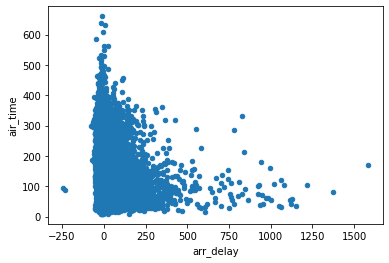

In [291]:
data = df_flights[['arr_delay','air_time']]
data.plot.scatter(x='arr_delay', y='air_time')


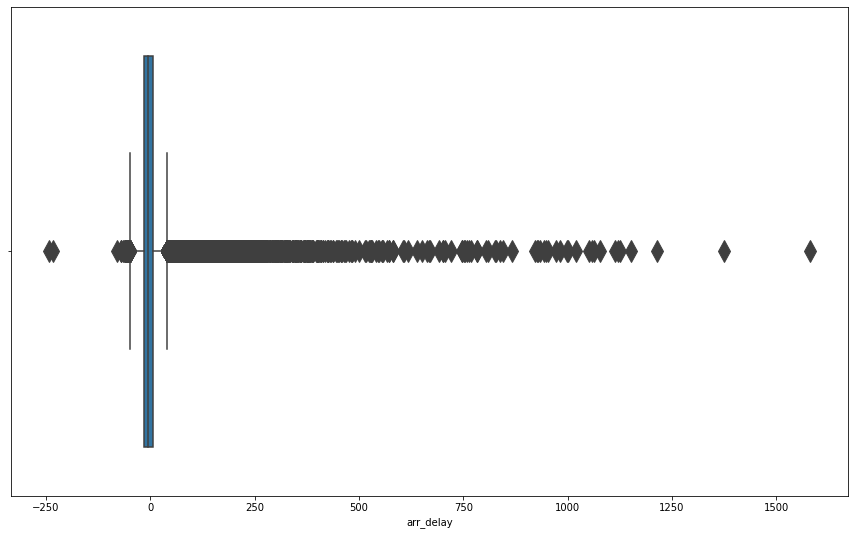

In [292]:
fig, ax = plt.subplots(figsize = (15,9))
ax = sns.boxplot(x=df_flights['arr_delay'],fliersize=15, )

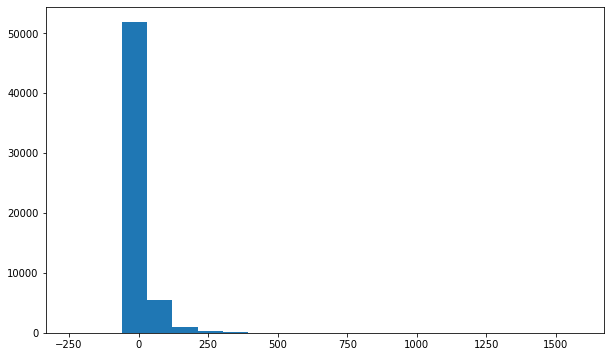

In [293]:
# create the figure and axes, set the figure size
fig, ax = plt.subplots(figsize = (10,6))

# histogram
ax.hist(x=df_flights['arr_delay'],bins=20)
plt.show()

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [294]:
month_delay = df_flights[df_flights['arr_delay']>0]


In [295]:
month_delay['fl_date'].count()

20313

In [296]:
# month_delay = month_delay.groupby(pd.Grouper(freq="M"))
month_delay_gp = month_delay.groupby(month_delay['fl_date'].dt.strftime('%B'))['arr_delay'].mean().sort_values()
month_delay_gp

fl_date
October      33.386941
November     34.171824
March        34.518160
September    36.010043
January      39.053630
April        39.063725
December     40.130337
June         42.500766
May          42.732838
July         43.832733
February     45.671765
August       46.855888
Name: arr_delay, dtype: float64

In [297]:
df_plot = month_delay['fl_date'].dt.month.value_counts()\
                    .rename_axis('month')\
                    .to_frame('count_delays')\
                    .reset_index()\
                    .sort_values('month')
df_plot

,month,count_delays
9,1,1529
8,2,1569
6,3,1652
7,4,1632
4,5,1748
0,6,1957
1,7,1943
2,8,1936
11,9,1394
5,10,1654


#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [298]:
dep_delays_samples = df_flights[df_flights['dep_delay']>0]
arr_delay_samples = df_flights[df_flights['arr_delay']>0]

In [299]:
dep_Random_delays = dep_delays_samples.sample(n=100, random_state=1)
arr_Random_delays = arr_delay_samples.sample(n=100, random_state=1)

In [300]:
import requests
import json

In [301]:
url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx?'

In [302]:
dep_weather_list = []

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [303]:
taxi_time = df_flights[['taxi_out','taxi_in','dep_time','arr_time']]

In [304]:
taxi_time

,taxi_out,taxi_in,dep_time,arr_time
0,21.0,3.0,828.0,955.0
1,12.0,8.0,1337.0,1445.0
2,7.0,6.0,1720.0,1757.0
3,34.0,7.0,1049.0,1303.0
4,11.0,6.0,619.0,844.0
...,...,...,...,...
59995,16.0,4.0,1351.0,1515.0
59996,30.0,7.0,1149.0,1828.0
59997,62.0,15.0,742.0,931.0
59998,21.0,4.0,1124.0,1243.0


In [305]:
taxi_time['dep_time_hr'] = round(taxi_time['dep_time']/100)
taxi_time['arr_time_hr'] = round(taxi_time['arr_time']/100)
taxi_time.drop(columns=['dep_time','arr_time'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,taxi_out,taxi_in,dep_time_hr,arr_time_hr
0,21.0,3.0,8.0,10.0
1,12.0,8.0,13.0,14.0
2,7.0,6.0,17.0,18.0
3,34.0,7.0,10.0,13.0
4,11.0,6.0,6.0,8.0
...,...,...,...,...
59995,16.0,4.0,14.0,15.0
59996,30.0,7.0,11.0,18.0
59997,62.0,15.0,7.0,9.0
59998,21.0,4.0,11.0,12.0


In [306]:
dp_hour_taxi_time_count = taxi_time.groupby(['dep_time_hr']).count()['taxi_out'].reset_index().sort_values(by='dep_time_hr')
                              
dp_hour_taxi_time_count



,dep_time_hr,taxi_out
0,0.0,225
1,1.0,91
2,2.0,29
3,3.0,20
4,4.0,22
5,5.0,1261
6,6.0,4051
7,7.0,3712
8,8.0,3885
9,9.0,3262


In [307]:
dp_hour_taxi_time = taxi_time.groupby(taxi_time['dep_time_hr'])['taxi_out'].mean().reset_index()
dp_hour_taxi_time

,dep_time_hr,taxi_out
0,0.0,16.635556
1,1.0,15.439560
2,2.0,12.862069
3,3.0,11.050000
4,4.0,15.045455
5,5.0,14.781126
6,6.0,16.787460
7,7.0,17.691002
8,8.0,19.030888
9,9.0,18.546597


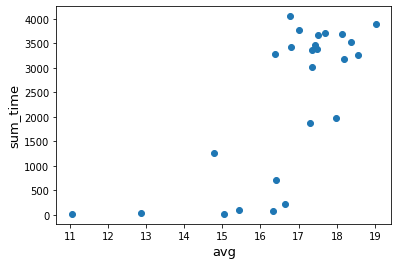

In [308]:
fig, ax = plt.subplots()
ax.scatter(x = dp_hour_taxi_time['taxi_out'], y = dp_hour_taxi_time_count['taxi_out'])
plt.ylabel('sum_time', fontsize=13)
plt.xlabel('avg', fontsize=13)
plt.show()

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [309]:
dep_delay = df_flights[df_flights['dep_delay']>0]

In [310]:
total_dep_delay = dep_delay.count()['dep_delay']
total_dep_delay 

19864

In [311]:
arr_delay_ = dep_delay[dep_delay['arr_delay']>0]

In [312]:
total_arr_delay_ = arr_delay_.count()['arr_delay']
total_arr_delay_

14473

<BarContainer object of 2 artists>

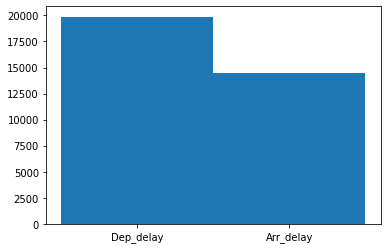

In [313]:
fig = plt.figure()
s = fig.add_subplot(111)
s.bar([1, 2], [total_dep_delay , total_arr_delay_], width=1, tick_label=['Dep_delay', 'Arr_delay'], align='center')


#### **Task 6**: How many states cover 50% of US air traffic? 

In [314]:
df_trafic = df_flights[['origin_city_name']]

In [315]:
df_trafic['state'] = df_trafic['origin_city_name'].str[-2:]
df_trafic

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,origin_city_name,state
0,"Atlanta, GA",GA
1,"Atlanta, GA",GA
2,"Kahului, HI",HI
3,"Newark, NJ",NJ
4,"Tampa, FL",FL
...,...,...
59995,"Oakland, CA",CA
59996,"Seattle, WA",WA
59997,"Charlotte, NC",NC
59998,"Atlanta, GA",GA


In [316]:
total_state_flights_mean = df_trafic.groupby(by=['state']).count().reset_index().sort_values(by='origin_city_name')
total_state_flights_mean

,state,origin_city_name
43,TT,13
47,VI,29
51,WV,69
52,WY,79
48,VT,79
29,NH,84
24,MS,97
41,SD,99
15,KS,125
27,ND,141


In [317]:
total_state_flights_mean['origin_city_name'] = ((total_state_flights_mean['origin_city_name']/60000)*100)


In [318]:
total_state_flights_mean.sort_values('origin_city_name',ascending=False).head(round(0.5*len(total_state_flights_mean)))

,state,origin_city_name
4,CA,10.913333
44,TX,9.910000
8,FL,7.281667
13,IL,6.358333
9,GA,5.333333
33,NY,5.108333
26,NC,4.463333
5,CO,4.016667
37,PA,3.063333
7,DC,2.915000


#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay?

In [319]:
dep_delay = df_flights[df_flights['dep_delay']>0]

In [320]:
avg_flight_time_delay = dep_delay['air_time'].median()
avg_flight_time_delay

93.0

In [321]:
on_time_flights = df_flights[df_flights['dep_delay']<=0]

In [322]:
avg_flight_time_on_time = on_time_flights['air_time'].median()
avg_flight_time_on_time

87.0

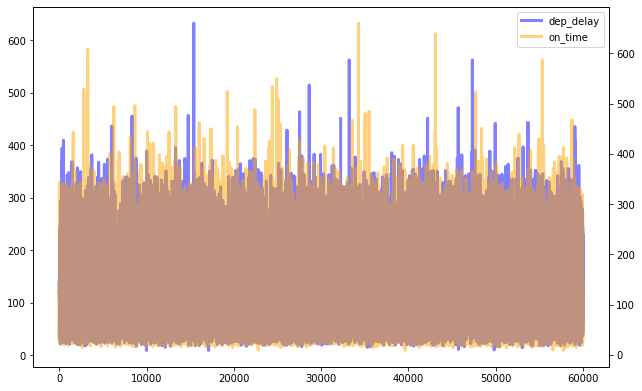

In [323]:
# Plot two lines with different scales on the same plot
fig = plt.figure(figsize=(8, 5))
line_weight = 3
alpha = .5
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
# This is the magic that joins the x-axis
ax2 = ax1.twinx()
lns1 = ax1.plot(dep_delay['air_time'], color='blue', lw=line_weight, alpha=alpha, label='dep_delay')
lns2 = ax2.plot(on_time_flights['air_time'], color='orange', lw=line_weight, alpha=alpha, label='on_time')
# Solution for having two legends
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
        
plt.show()

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [324]:
df_flights['air_time'].describe()

count    58805.000000
mean       107.779492
std         69.508517
min          9.000000
25%         58.000000
50%         89.000000
75%        137.000000
max        660.000000
Name: air_time, dtype: float64

In [325]:
flights_time = df_flights[['dep_time','air_time',]]
flights_time

,dep_time,air_time
0,828.0,63.0
1,1337.0,108.0
2,1720.0,24.0
3,1049.0,93.0
4,619.0,128.0
...,...,...
59995,1351.0,64.0
59996,1149.0,242.0
59997,742.0,92.0
59998,1124.0,114.0


In [326]:
def haul(x):
  if x >137:
    return 'LONG'
  elif x <58:
    return 'SHORT'
  else:
    return 'MEDIUM'

In [327]:
flights_time['flight_time_dur'] = flights_time['air_time'].apply(haul)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [328]:
flights_time

,dep_time,air_time,flight_time_dur
0,828.0,63.0,MEDIUM
1,1337.0,108.0,MEDIUM
2,1720.0,24.0,SHORT
3,1049.0,93.0,MEDIUM
4,619.0,128.0,MEDIUM
...,...,...,...
59995,1351.0,64.0,MEDIUM
59996,1149.0,242.0,LONG
59997,742.0,92.0,MEDIUM
59998,1124.0,114.0,MEDIUM


In [329]:
flights_time['dep_time'] = round(flights_time['dep_time']/100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [330]:
departure_time = flights_time.groupby(['flight_time_dur','dep_time']).count() #.agg({'dep_time':['median']})

In [331]:
departure_time.groupby('flight_time_dur').head(5)

air_time
flight_time_dur dep_time          
LONG            0.0            147
                1.0             60
                2.0             23
                3.0             17
                4.0              9
MEDIUM          0.0             47
                1.0             24
                2.0              4
                3.0              2
                4.0              8
SHORT           0.0             30
                1.0              6
                2.0              2
                3.0              1
                4.0              5

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [332]:
list_dep = df_flights['origin']
list_arr = df_flights['dest']
total_list = list_dep.append(list_arr)

In [333]:
total_list = pd.DataFrame(total_list, columns=['air_port'])

In [334]:
top_10_air = total_list['air_port'].value_counts().rename_axis('air_port').to_frame('total_flights')\
                                  .reset_index().sort_values('total_flights', ascending = False)
top_10_airp = top_10_air.head(10)

In [335]:
list_top_10 = ['ATL','ORD','DFW','DEN',	'CLT','LAX', 'SEA','SFO','PHX','IAH'	]

In [336]:
dep = df_passengers[df_passengers['origin'].isin(list_top_10)]

In [337]:
arr = df_passengers[df_passengers['dest'].isin(list_top_10)]

In [338]:
pass_dep = dep[['origin','passengers']].rename(columns={'origin': 'air_port'})
pass_arr = arr[['dest','passengers']].rename(columns={'dest': 'air_port'})
list_of_top_airpot_pass = pass_dep.append(pass_arr)

In [339]:
total_pass_per_airp = list_of_top_airpot_pass.groupby(by='air_port').sum()['passengers']
total_pass_per_airp

air_port
ATL    13600252.0
CLT     5614999.0
DEN     7134669.0
DFW     8294103.0
IAH     5236490.0
LAX    10509225.0
ORD     9926273.0
PHX     5752034.0
SEA     6068860.0
SFO     7099819.0
Name: passengers, dtype: float64

In [340]:
top_airport_pass = top_10_airp.merge(total_pass_per_airp,how='inner', on='air_port')
top_airport_pass

,air_port,total_flights,passengers
0,ORD,5949,9926273.0
1,ATL,5925,13600252.0
2,DFW,4488,8294103.0
3,DEN,4167,7134669.0
4,LAX,3811,10509225.0
5,CLT,3693,5614999.0
6,SEA,2821,6068860.0
7,PHX,2734,5752034.0
8,SFO,2680,7099819.0
9,IAH,2680,5236490.0


#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [341]:
df_flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [342]:
df_fuel_consumption.columns

Index(['month', 'airline_id', 'unique_carrier', 'carrier', 'carrier_name',
       'carrier_group_new', 'sdomt_gallons', 'satl_gallons', 'spac_gallons',
       'slat_gallons', 'sint_gallons', 'ts_gallons', 'tdomt_gallons',
       'tint_gallons', 'total_gallons', 'sdomt_cost', 'satl_cost', 'spac_cost',
       'slat_cost', 'sint_cost', 'ts_cost', 'tdomt_cost', 'tint_cost',
       'total_cost', 'year'],
      dtype='object')

In [343]:
#Monthe delay per carrier
arr_delay = df_flights[df_flights['arr_delay']>0]
delay_per_carries = pd.DataFrame(arr_delay.groupby(by=['mkt_carrier',arr_delay['fl_date'].dt.strftime('%B')]).count()['arr_delay'])
delay_per_carries                                  


arr_delay
mkt_carrier fl_date             
AA          April            445
            August           527
            December         499
            February         443
            January          465
...                          ...
WN          March            315
            May              313
            November         253
            October          292
            September        199

[123 rows x 1 columns]

In [344]:
# Find out distance covered monthly by different air carriers

distance_per_carries = pd.DataFrame(arr_delay.groupby(by=['mkt_carrier',arr_delay['fl_date'].dt.strftime('%B')]).sum()['distance'])
distance_per_carries

distance
mkt_carrier fl_date            
AA          April      308517.0
            August     397784.0
            December   335196.0
            February   307539.0
            January    304307.0
...                         ...
WN          March      233382.0
            May        237621.0
            November   190675.0
            October    216818.0
            September  144098.0

[123 rows x 1 columns]

In [359]:
distance_p_carr_total = pd.DataFrame(arr_delay.groupby(by=['mkt_unique_carrier']).sum()['distance'].rename_axis('carrier'))
distance_p_carr_total

,distance
carrier,
AA,3899510.0
AS,1042041.0
B6,983128.0
DL,2622597.0
F9,396980.0
G4,272041.0
HA,222715.0
NK,457411.0
UA,3195617.0


In [346]:
df_passengers.columns

Index(['departures_scheduled', 'departures_performed', 'payload', 'seats',
       'passengers', 'freight', 'mail', 'distance', 'ramp_to_ramp', 'air_time',
       'unique_carrier', 'airline_id', 'unique_carrier_name', 'region',
       'carrier', 'carrier_name', 'carrier_group', 'carrier_group_new',
       'origin_airport_id', 'origin_city_market_id', 'origin',
       'origin_city_name', 'origin_country', 'origin_country_name',
       'dest_airport_id', 'dest_city_market_id', 'dest', 'dest_city_name',
       'dest_country', 'dest_country_name', 'aircraft_group', 'aircraft_type',
       'aircraft_config', 'year', 'month', 'distance_group', 'class',
       'data_source'],
      dtype='object')

In [347]:
#Find out number of passengers that were carried by different air carriers
list_pass = df_passengers[df_passengers['passengers']>0]
passa_per_carries = pd.DataFrame(list_pass.groupby(by=['carrier']).sum()['passengers'])
passa_per_carries

,passengers
carrier,
02Q,68.0
04Q,3955.0
07Q,518.0
09Q,54811.0
0BQ,13.0
...,...
Z3,2694.0
ZE,4564.0
ZK,5948.0


In [348]:
# Find out total fuel comsumption per air carrier.
cunsump_per_carries = pd.DataFrame(df_fuel_consumption.groupby(by=['carrier']).sum()['total_gallons'])
cunsump_per_carries

,total_gallons
carrier,
09Q,41034111.0
0JQ,841615.0
0WQ,3253401.0
16,0.0
1BQ,6672792.0
...,...
X9,176878857.0
XP,19013295.0
YV,0.0


In [360]:
# Use this information to get the average fuel comsumption per passenger per km. 
#Is this higher for the airlines with bigger average delays?
test = passa_per_carries.merge(cunsump_per_carries,how="outer", on="carrier") # do left join


In [361]:
final_list = test.merge(distance_p_carr_total,how="outer", on="carrier")

In [362]:
def summ(x):
  if x['passengers']:
    return (x['total_gallons']/x['passengers'])
  
final_list['gallons_per_passeger'] = final_list.apply(summ, axis=1)
final_list

,passengers,total_gallons,distance,gallons_per_passeger
carrier,,,,
02Q,68.0,NaN,NaN,NaN
04Q,3955.0,NaN,NaN,NaN
07Q,518.0,NaN,NaN,NaN
09Q,54811.0,41034111.0,NaN,748.64737
0BQ,13.0,NaN,NaN,NaN
...,...,...,...,...
PO,NaN,875462934.0,NaN,NaN
PRQ,NaN,0.0,NaN,NaN
U7,NaN,28078606.0,NaN,NaN


In [365]:
def perct(x):
  if x['passengers']:
    return (x['gallons_per_passeger']/x['distance'])

final_list['cons_ppl_km'] = final_list.apply(perct, axis=1)


In [379]:
list_delay = final_list.loc[final_list['cons_ppl_km']>0]
list_delay

,passengers,total_gallons,distance,gallons_per_passeger,cons_ppl_km
carrier,,,,,
AA,18698764.0,1.663489e+10,3899510.0,889.624922,0.000228
AS,3783562.0,2.678455e+09,1042041.0,707.919009,0.000679
B6,5450186.0,3.767060e+09,983128.0,691.180044,0.000703
DL,19645203.0,1.655025e+10,2622597.0,842.457587,0.000321
F9,2186058.0,1.125294e+09,396980.0,514.759655,0.001297
G4,1653940.0,8.497621e+08,272041.0,513.780459,0.001889
HA,1128666.0,1.213558e+09,222715.0,1075.214869,0.004828
NK,3239146.0,1.663308e+09,457411.0,513.501879,0.001123
UA,13158071.0,1.595691e+10,3195617.0,1212.708687,0.000379


In [392]:
list_delay['cons_ppl_km']

carrier
AA    0.000228
AS    0.000679
B6    0.000703
DL    0.000321
F9    0.001297
G4    0.001889
HA    0.004828
NK    0.001123
UA    0.000379
VX    0.027081
WN    0.000180
Name: cons_ppl_km, dtype: float64

#### No delays 

In [370]:
ontime = df_flights[df_flights['arr_delay']<=0]
distance_ontime_carr_total = pd.DataFrame(ontime.groupby(by=['mkt_unique_carrier']).sum()['distance'].rename_axis('carrier'))
distance_ontime_carr_total

,distance
carrier,
AA,6755438.0
AS,2028976.0
B6,1452456.0
DL,6487165.0
F9,546770.0
G4,395965.0
HA,268189.0
NK,985609.0
UA,5826768.0


In [374]:
final_list_ontime = passa_per_carries.merge(cunsump_per_carries,how="outer", on="carrier").merge(distance_ontime_carr_total,how="outer", on="carrier")

In [375]:
def summ(x):
  if x['passengers']:
    return (x['total_gallons']/x['passengers'])
  
final_list_ontime['gallons_per_passeger'] = firts_merge.apply(summ, axis=1)
final_list_ontime

,passengers,total_gallons,distance,gallons_per_passeger
carrier,,,,
02Q,68.0,NaN,NaN,NaN
04Q,3955.0,NaN,NaN,NaN
07Q,518.0,NaN,NaN,NaN
09Q,54811.0,41034111.0,NaN,748.64737
0BQ,13.0,NaN,NaN,NaN
...,...,...,...,...
PO,NaN,875462934.0,NaN,NaN
PRQ,NaN,0.0,NaN,NaN
U7,NaN,28078606.0,NaN,NaN


In [376]:
def perct(x):
  if x['passengers']:
    return (x['gallons_per_passeger']/x['distance'])

final_list_ontime['cons_ppl_km'] = final_list_ontime.apply(perct, axis=1)

In [378]:
list_ontime = final_list_ontime.loc[final_list['cons_ppl_km']>0]
list_ontime

,passengers,total_gallons,distance,gallons_per_passeger,cons_ppl_km
carrier,,,,,
AA,18698764.0,1.663489e+10,6755438.0,889.624922,0.000132
AS,3783562.0,2.678455e+09,2028976.0,707.919009,0.000349
B6,5450186.0,3.767060e+09,1452456.0,691.180044,0.000476
DL,19645203.0,1.655025e+10,6487165.0,842.457587,0.000130
F9,2186058.0,1.125294e+09,546770.0,514.759655,0.000941
G4,1653940.0,8.497621e+08,395965.0,513.780459,0.001298
HA,1128666.0,1.213558e+09,268189.0,1075.214869,0.004009
NK,3239146.0,1.663308e+09,985609.0,513.501879,0.000521
UA,13158071.0,1.595691e+10,5826768.0,1212.708687,0.000208


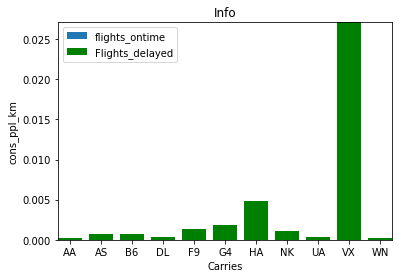

In [393]:
plt.bar(list_ontime.index, list_ontime['cons_ppl_km'], label= 'flights_ontime')
plt.bar(list_delay.index, list_delay['cons_ppl_km'], label= 'Flights_delayed',color='g')
plt.legend()
plt.autoscale(tight=True)
plt.title('Info')
plt.xlabel('Carries')
plt.ylabel('cons_ppl_km')
plt.show()

In [396]:
import plotly.graph_objs as go
# Trace - gold medals
trace1 = go.Bar(
    x = list_ontime.index, # NOC stands for the National Olympic Committee
    y = list_ontime['cons_ppl_km'],
    name = 'flights_ontime',
    marker = dict(color='#FFD700') # set the marker color to gold
)

# trace - silver medals
trace2 = go.Bar(
    x = list_delay.index, # NOC stands for the National Olympic Committee
    y = list_delay['cons_ppl_km'],
    name = 'Flights_delayed',
    marker = dict(color='#9EA0a1') # set the marker color to silver
)

# create the data
data = [trace1, trace2]

#create the layout
layout = go.Layout(
        title = 'Consumption On-time x Delayed')

# create the figure
fig = go.Figure(data=data, layout = layout)
fig.show()